# Final Project - Breast Cancer Diagnosis Based on Cell Nuclei Features

Carolyn Nohejl

# Exploratory Data Analysis Notebook

# Import Packages

In [1]:
import os
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)
import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')



from IPython.display import Image
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification;
from sklearn import preprocessing, neighbors, model_selection

from sklearn import tree, ensemble, metrics, model_selection, externals

/Users/cnohejl/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Data

In [2]:
df = pd.read_csv(os.path.join('breast_cancer_data.csv'))

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.shape

(569, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [6]:
df.isnull().sum().sum()

0

- There are no missing values/not a numbers in the data set. 
- Next I checked for any "0"s in the dataset manually. They were only found in the concavity and concave points columns (13 of them) for benign cells. I left these cases in as healthy cells are known to be round (therefore it makes sense that concavity could be 0), rather than deleting based on the assumption that the measurement was not taken.

In [7]:
df.columns

Index([u'id', u'diagnosis', u'radius_mean', u'texture_mean', u'perimeter_mean',
       u'area_mean', u'smoothness_mean', u'compactness_mean',
       u'concavity_mean', u'concave points_mean', u'symmetry_mean',
       u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
       u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
       u'concave points_se', u'symmetry_se', u'fractal_dimension_se',
       u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
       u'smoothness_worst', u'compactness_worst', u'concavity_worst',
       u'concave points_worst', u'symmetry_worst', u'fractal_dimension_worst'],
      dtype='object')

Summary:
- 569 samples, 30 independent variables, one classifier (benign or malignant) and patient id
- No missing data or NaN
- Recognized that the concave points mean, se, and worst has a space in the name between "concave" and "points". I will rename the columns below to remove the space in the name.

In [8]:
df.rename(columns = {'concave points_mean': 'concave_points_mean', 'concave points_se': 'concave_points_se', 'concave points_worst': 'concave_points_worst'}, inplace = True)

Confirmed the column names no longer have spaces:

In [9]:
df.columns

Index([u'id', u'diagnosis', u'radius_mean', u'texture_mean', u'perimeter_mean',
       u'area_mean', u'smoothness_mean', u'compactness_mean',
       u'concavity_mean', u'concave_points_mean', u'symmetry_mean',
       u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
       u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
       u'concave_points_se', u'symmetry_se', u'fractal_dimension_se',
       u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
       u'smoothness_worst', u'compactness_worst', u'concavity_worst',
       u'concave_points_worst', u'symmetry_worst', u'fractal_dimension_worst'],
      dtype='object')

Class distribution:

In [10]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

Confirms 357 samples are benign and 212 are malignant, around 63% benign : 37% malignant.  This is a good class distribution.

Changed the diagnosis in the train and test sets from B and M to 0 and 1 respectively to facilitate modeling later on:

In [11]:
df.replace(["M", "B"],["1","0"],inplace=True)

In [12]:
df.diagnosis.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: object

# Split data into train and test sets (70/30)¶

In [13]:
df_train, df_test = train_test_split(df,test_size=0.3, random_state=42)

Ensured that train and test datasets had similar ratios of malignant and benign:

In [14]:
df_train.diagnosis.value_counts()

0    249
1    149
Name: diagnosis, dtype: int64

In [15]:
df_test.diagnosis.value_counts()

0    108
1     63
Name: diagnosis, dtype: int64

Confirmed:
- Full dataset: 212 of 569 samples are malignant = 37% malignant
- Train dataset: 149 of 398 samples are malignant = 37% malignant
- Test dataset: 63 of 171 samples are malignant = 37% malignant

# Explore Data

In [16]:
df_train.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,...,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
149,869931,0,13.74,17.91,88.12,...,0.1824,0.1564,0.06019,0.2350,0.07014
124,865468,0,13.37,16.39,86.10,...,0.2531,0.3308,0.08978,0.2048,0.07628
421,906564,0,14.69,13.98,98.22,...,0.3635,0.3219,0.11080,0.2827,0.09208
195,875878,0,12.91,16.33,82.53,...,0.1506,0.1764,0.08235,0.3024,0.06949
545,922576,0,13.62,23.23,87.19,...,0.1517,0.1049,0.07174,0.2642,0.06953


In [17]:
df_train.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,...,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,3.980000e+02,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000
mean,3.012241e+07,14.176078,19.159171,92.256332,659.770854,...,0.249086,0.268497,0.113839,0.288300,0.083537
std,1.270358e+08,3.535730,4.214074,24.289529,358.865452,...,0.148622,0.196139,0.063886,0.062318,0.017518
min,8.915000e+03,7.691000,9.710000,48.340000,170.400000,...,0.034320,0.000000,0.000000,0.156500,0.055040
25%,8.682072e+05,11.752500,16.170000,75.805000,426.175000,...,0.147325,0.116475,0.063885,0.247775,0.071155
50%,9.053455e+05,13.275000,18.700000,85.980000,546.250000,...,0.209250,0.226200,0.099270,0.280750,0.080165
75%,8.813066e+06,16.090000,21.555000,105.625000,797.400000,...,0.341600,0.384700,0.160400,0.315650,0.091745
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,...,0.937900,0.903400,0.275600,0.663800,0.173000


# Data Visualization

The authors (Street, Wolberg, et al) claimed that all features were numerically modeled such that larger values will typically indicate higher likelihood of malignancy.
- I used plots below to assess if this is generally true, assessing the mean, worst, and standard error of the features separately. 
- I also created a correlation matrix to confirm that the means and worst of all variables are positively correlated, as I expect them to be given the information from the authors.  I wasn't sure about the standard error, expect that this would vary based on how fast the cells were growing (how different they were in within the benign or malignant groups).

### Means: 

Created a dataframe "df_train_means" to look at the correlation of the means- I expected it to be high positive correlation given the visual information in the plots above.

In [18]:
df_train_means = df_train[ ['diagnosis','radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean','smoothness_mean', 'compactness_mean','concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

''

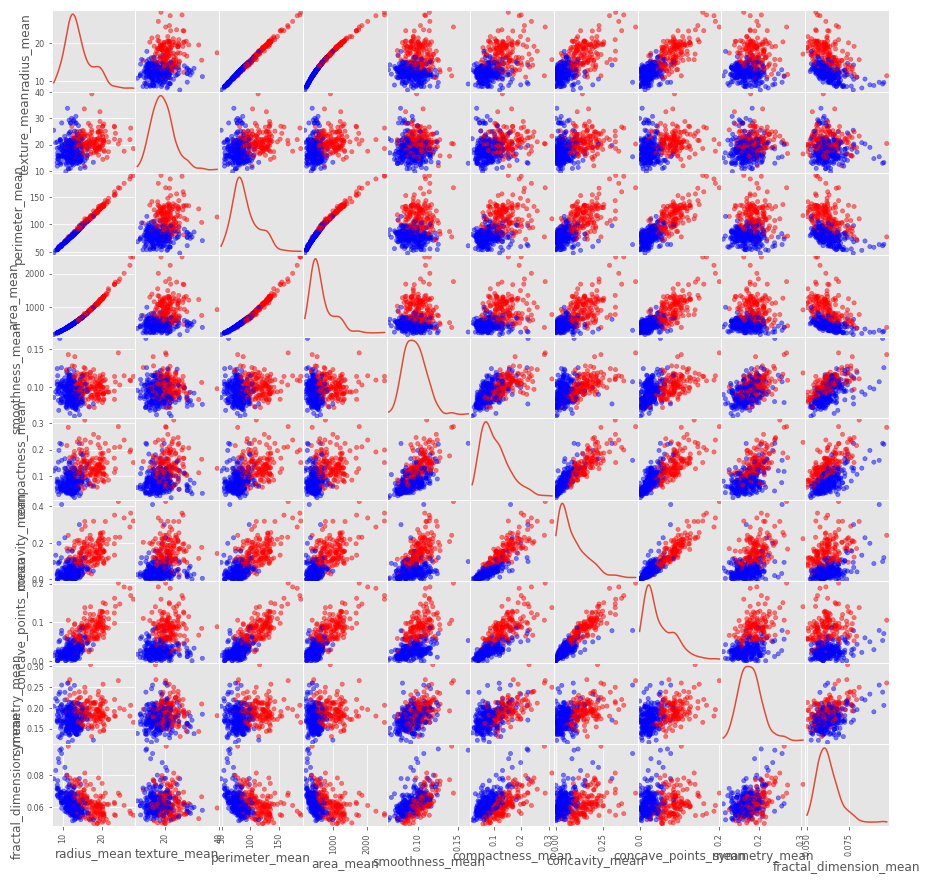

In [19]:
color = df_train_means.diagnosis.map({'1': 'red', '0': 'blue'})

pd.tools.plotting.scatter_matrix(
    df_train_means,
    diagonal = 'kde', s = 75, c = color, figsize = (15, 15)
)
;

Larger values for smoothness, symmetry, fractal dimension, texture didn't seem to indicate malignancy. 

In [20]:
corr_train_means = df_train_means.corr()

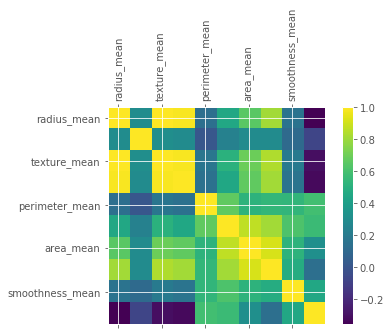

In [21]:
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr_train_means))
subplot.set_xticklabels([None] + list(corr_train_means.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr_train_means.columns));

As expected, many of these features were highly correlated.

### Worst:

Followed the same approach as means.

In [22]:
df_train_worst = df_train[ ['diagnosis','radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst','smoothness_worst', 'compactness_worst','concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']]

''

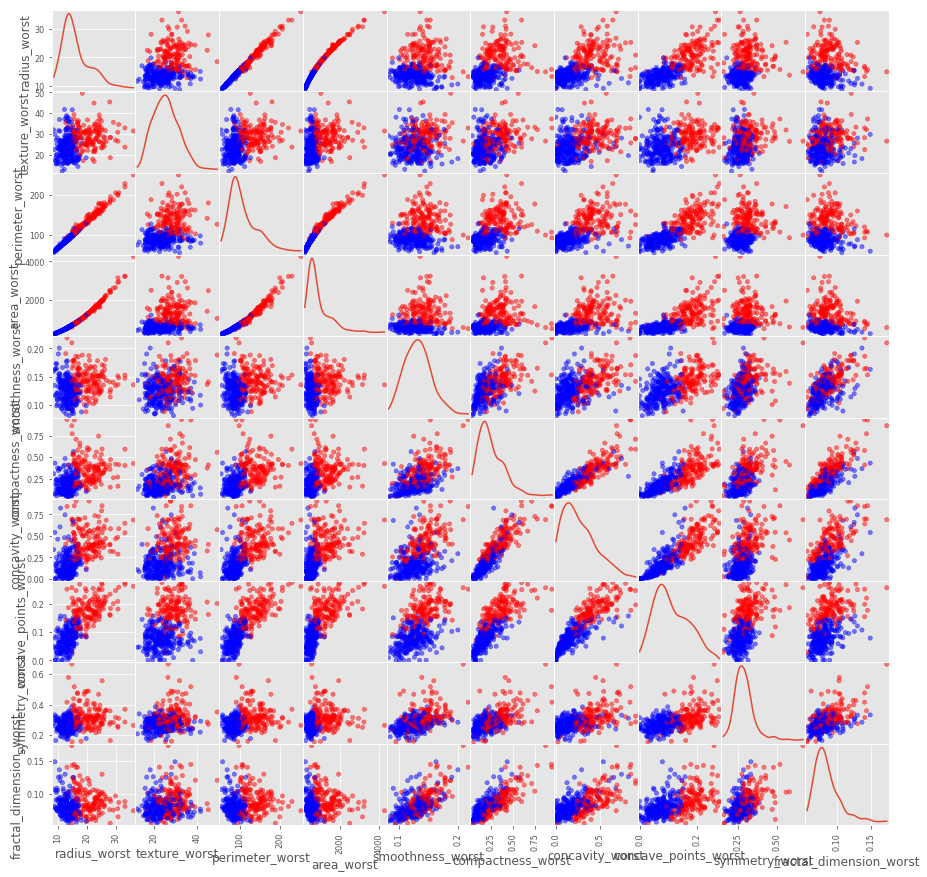

In [23]:
color = df_train_worst.diagnosis.map({'1': 'red', '0': 'blue'})

pd.tools.plotting.scatter_matrix(
    df_train_worst,
    diagonal = 'kde', s = 75, c = color, figsize = (15, 15)
)
;

Higher values for texture, smoothness, symmetry, and fractal dimension again did not seem to suggest malignancy.

In [24]:
corr_train_worst = df_train_worst.corr()

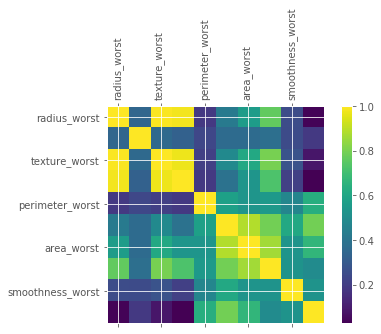

In [25]:
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr_train_worst))
subplot.set_xticklabels([None] + list(corr_train_worst.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr_train_worst.columns));

### Standard Error:

Followed the same approach as means and worst.

In [26]:
df_train_se=df_train[ ['diagnosis','radius_se', 'texture_se', 'perimeter_se', 'area_se','smoothness_se', 'compactness_se','concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se']]

''

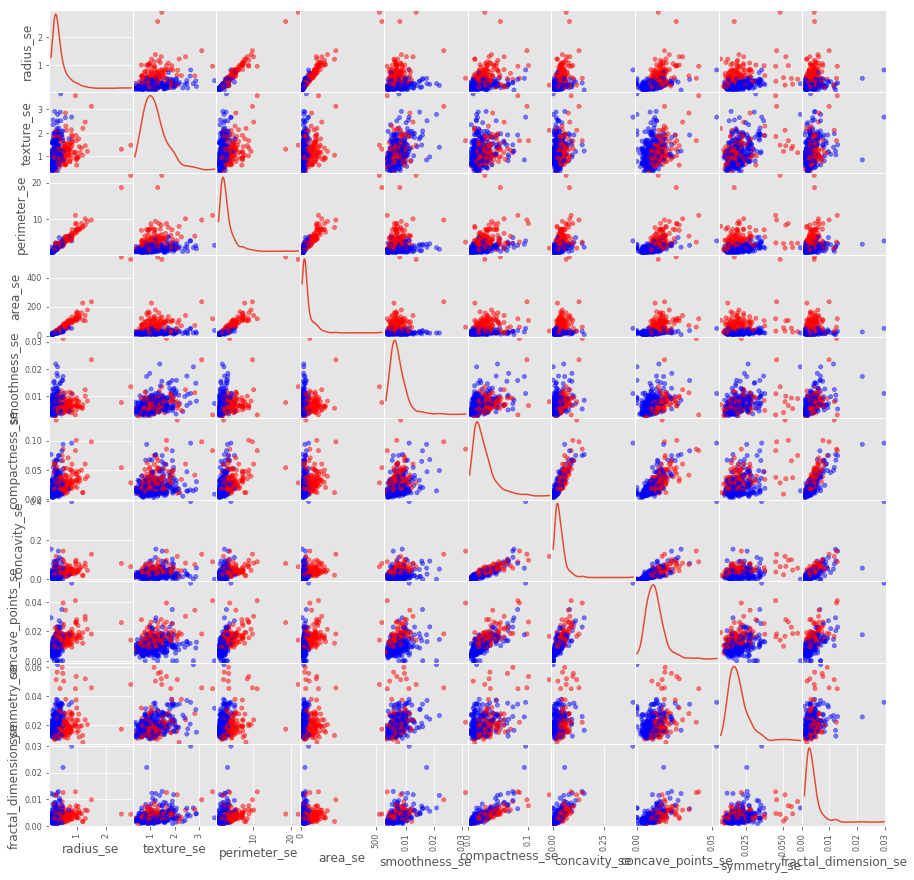

In [27]:
color = df_train_se.diagnosis.map({'1': 'red', '0': 'blue'})

pd.tools.plotting.scatter_matrix(
    df_train_se,
    diagonal = 'kde', s = 75, c = color, figsize = (15, 15)
)
;

Relationship between higher values and malignancy is less clear.

In [28]:
corr_train_se = df_train_se.corr()

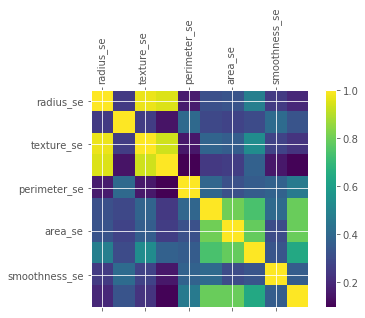

In [29]:
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr_train_se))
subplot.set_xticklabels([None] + list(corr_train_se.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr_train_se.columns));

Based on the heatmaps, SE features are the least correlated, followed by worst, then and means. Will balance this result with random forest in my selection of top variables.

# Data Visualization - Outliers

Divided training data into a dataframe with malignant samples, and a separate dataframe with benign samples to evaluate the outliers.


In [30]:
df_train_benign=df_train[df_train['diagnosis'] == "0"]
df_train_benign.shape

(249, 32)

In [31]:
df_train_malignant=df_train[df_train['diagnosis'] == "1"]
df_train_malignant.shape

(149, 32)

Replicated these dataframes into an "outlier" dataframes.  Then used a for loop to remove outliers.

In [32]:
df_train_benign_outlier = df_train_benign
df_train_benign_outlier.shape

(249, 32)

In [33]:
df_train_malignant_outlier = df_train_malignant
df_train_malignant_outlier.shape

(149, 32)

In [34]:
for col_name in df_train_benign_outlier.columns:
    if col_name in ['id', 'diagnosis']:
        continue
    
    Q1 = df_train_benign_outlier[col_name].quantile(0.25)
    Q3 = df_train_benign_outlier[col_name].quantile(0.75)
    IQR = Q3 - Q1
    df_train_benign_outlier = df_train_benign_outlier[(df_train_benign_outlier[col_name] \
            > (Q1 - 1.5 * IQR)) & (df_train_benign_outlier[col_name] < (Q3 + 1.5 * IQR))]
    print(col_name, Q1, Q3, df_train_benign_outlier.shape)

('radius_mean', 11.22, 13.38, (246, 32))
('texture_mean', 15.1875, 19.784999999999997, (234, 32))
('perimeter_mean', 71.3475, 86.07, (234, 32))
('area_mean', 381.375, 553.05, (232, 32))
('smoothness_mean', 0.083705, 0.1007, (231, 32))
('compactness_mean', 0.05623500000000001, 0.097875, (224, 32))
('concavity_mean', 0.020415, 0.058492499999999996, (219, 32))
('concave_points_mean', 0.014865, 0.030934999999999997, (212, 32))
('symmetry_mean', 0.1555, 0.186275, (209, 32))
('fractal_dimension_mean', 0.05853, 0.06562, (205, 32))
('radius_se', 0.21, 0.3278, (200, 32))
('texture_se', 0.7655749999999999, 1.3507500000000001, (194, 32))
('perimeter_se', 1.43575, 2.225, (192, 32))
('area_se', 14.852500000000001, 23.6225, (188, 32))
('smoothness_se', 0.0049015, 0.007831, (184, 32))
('compactness_se', 0.01053, 0.021825000000000004, (174, 32))
('concavity_se', 0.010135, 0.0233475, (163, 32))
('concave_points_se', 0.00583, 0.0099215, (161, 32))
('symmetry_se', 0.01494, 0.021519999999999997, (155, 32)

In [35]:
for col_name in df_train_malignant_outlier.columns:
    if col_name in ['id', 'diagnosis']:
        continue
    
    Q1 = df_train_malignant_outlier[col_name].quantile(0.25)
    Q3 = df_train_malignant_outlier[col_name].quantile(0.75)
    IQR = Q3 - Q1
    df_train_malignant_outlier = df_train_malignant_outlier[(df_train_malignant_outlier[col_name] \
            > (Q1 - 1.5 * IQR)) & (df_train_malignant_outlier[col_name] < (Q3 + 1.5 * IQR))]
    print(col_name, Q1, Q3, df_train_malignant_outlier.shape)

('radius_mean', 14.95, 19.55, (146, 32))
('texture_mean', 18.9025, 23.2075, (142, 32))
('perimeter_mean', 97.29500000000002, 128.75, (142, 32))
('area_mean', 679.7, 1172.75, (141, 32))
('smoothness_mean', 0.0926, 0.1099, (138, 32))
('compactness_mean', 0.10679999999999999, 0.166, (136, 32))
('concavity_mean', 0.1056, 0.187, (134, 32))
('concave_points_mean', 0.0610225, 0.0969325, (134, 32))
('symmetry_mean', 0.174225, 0.207875, (132, 32))
('fractal_dimension_mean', 0.0564775, 0.065585, (131, 32))
('radius_se', 0.33925, 0.7201500000000001, (129, 32))
('texture_se', 0.9173, 1.3769999999999998, (122, 32))
('perimeter_se', 2.5545, 4.657, (120, 32))
('area_se', 33.092499999999994, 84.5925, (118, 32))
('smoothness_se', 0.0050392499999999995, 0.007962750000000001, (117, 32))
('compactness_se', 0.01877, 0.03414, (112, 32))
('concavity_se', 0.026465000000000002, 0.044505, (110, 32))
('concave_points_se', 0.010955, 0.015752500000000003, (108, 32))
('symmetry_se', 0.014425, 0.02045, (104, 32))
('

# Visualizing top features from Random Forest Model

[Random forest model is captured in the modeling notebook]

As shown below, the top 3 features from the random forest model have disparate benign and malignant distributions.

Concave points worst:

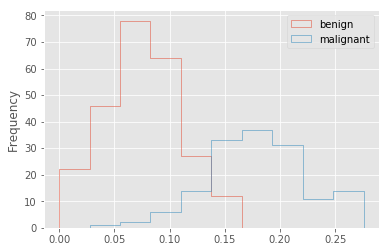

In [36]:
perimeter=pd.DataFrame({'benign': df_train_benign.concave_points_worst, 'malignant': df_train_malignant.concave_points_worst})

plt.figure();

perimeter.plot.hist(histtype='step');

Perimeter worst:

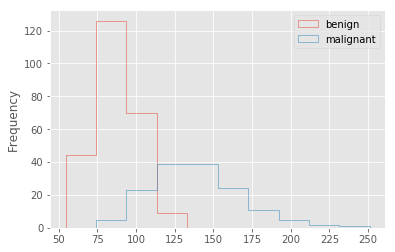

In [38]:
perimeter=pd.DataFrame({'benign': df_train_benign.perimeter_worst, 'malignant': df_train_malignant.perimeter_worst})

plt.figure();

perimeter.plot.hist(histtype='step');

Radius worst:

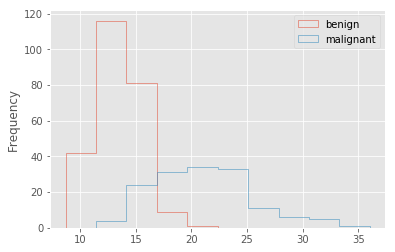

In [49]:
perimeter=pd.DataFrame({'benign': df_train_benign.radius_worst,'malignant': df_train_malignant.radius_worst, })

plt.figure();

perimeter.plot.hist(histtype='step');